## Minimum Spectral Entropy Demonstration (Phase and Delay)

This notebook demonstrates a method for controlling stochastic delay and phase noise in $H(\nu,t)e^{i(\phi_t+\epsilon_t \nu)}$, where $H(\nu,t)$ is the dynamic frequency response determined by dynamic cyclic spectroscopy, $\phi_t$ and $\epsilon_t$ are the unknown degenerate phase and delay at time $t$.

The method is based on minimizing the spectral entropy in $h(\tau,\omega)$ by varying $\phi_t$ and $\epsilon_t$.

In [1]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import psrchive

def freq2time(hf, axis=0):
    return ifft(hf, axis=axis, norm="ortho")

def time2freq(ht, axis=0):
    return fft(ht, axis=axis, norm="ortho")

## Spectral Entropy

Defined as $$U = - \sum_j \sum_k p_{jk} \log_2 p_{jk},$$
where $p_{jk}$ is the fractional power spectral density,

\begin{equation}
p_{jk} = P_{jk} \Sigma_P^{-1},
\end{equation}

$P_{jk} = | h^\prime(\tau_j;\omega_k) |^2$ is the power at a
given delay and Doppler shift, and

\begin{equation}
\Sigma_P =  \sum_j \sum_k P_{jk}
\end{equation}

is the total power summed over all delays and Doppler shifts, which remains constant
as the values of $\phi_t$ and $\epsilon_t$ are varied.

See https://www.overleaf.com/read/mjqhtxmtpmmd#19ec75 for derivation of the partial derivatives $dU/d\phi_t$ and $dU/d\epsilon_t$.

In [2]:
def spectral_entropy_grad(alpha, h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform
    and freq-to-delay inverse Fourier transform of the input h_time_freq after mupltiplying each row/time (except the first) by phi
    and shifting each row/time by delay epsilon

    Args:
    alpha: A 1D array of (Ntime - 1) real-valued phase shifts, in radians,
        and (Ntime - 1) real-valued delays, in radians per cycle, to be applied to each row except the first
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy and its gradient with respect to the phase shifts
    """

    Ntime, Nchan = h_time_freq.shape
    
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))
    dh_time_freq_prime_deps_oni = np.multiply(h_time_freq_prime, nus[np.newaxis, :])

    h_time_delay_prime = ifft(h_time_freq_prime, axis=1, norm="ortho")
    dh_time_delay_prime_deps_oni = ifft(dh_time_freq_prime_deps_oni, axis=1, norm="ortho")

    phasors = np.exp(1.j * phs)
    h_time_delay_prime = np.multiply(h_time_delay_prime, phasors[:, np.newaxis])
    dh_time_delay_prime_deps_oni = np.multiply(dh_time_delay_prime_deps_oni, phasors[:, np.newaxis])
    
    h_doppler_delay_prime = fft(h_time_delay_prime, axis=0, norm="ortho")
    
    power_spectrum = np.abs(h_doppler_delay_prime)**2
    
    total_power = np.sum(power_spectrum)
    power_spectrum /= total_power
    log_power_spectrum = np.log2(power_spectrum + 1e-16)
    entropy = -np.sum(power_spectrum * log_power_spectrum)

    weighted_ifft = ifft((1.+log_power_spectrum)*h_doppler_delay_prime, axis=0, norm="ortho")

    # partial derivatives with respect to phi_l
    gradient_phs = 2.0/total_power * np.sum( np.imag( np.conj(weighted_ifft)*h_time_delay_prime ), axis=1)
    grad_phs_power = np.sum(gradient_phs**2)

    # partial derivatives with respect to epsilon_l
    gradient_eps = 2.0/total_power * np.sum( np.imag( np.conj(weighted_ifft)*dh_time_delay_prime_deps_oni ), axis=1)    
    grad_eps_power = np.sum(gradient_eps**2)

    rms = np.sqrt(np.sum(phs**2) / (Ntime-1))
    print (f"rms={rms:.4g} rad; S={entropy} grad power phs={grad_phs_power:.4} eps={grad_eps_power:.4}")

    return entropy, np.concatenate((gradient_phs[1:],gradient_eps[1:]))

def spectral_entropy(h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform 
    of the input h_time_delay

    Args:
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy
    """
    nsub, nchan = h_time_freq.shape
    alpha = np.zeros(2*(nsub-1))
    entropy, grad = spectral_entropy_grad(alpha,h_time_freq)
    return entropy

## Minimize the spectral entropy using BFGS

In [3]:
from scipy.optimize import minimize

def circular(x):
    x[:] = np.fmod(x, 2.0*np.pi)

def minimize_spectral_entropy(h_time_freq):

    Ntime, Nchan = h_time_freq.shape
    initial_guess = np.zeros(2*(Ntime - 1))

    options = {"maxiter": 1000, "disp": True}

    result = minimize(
        spectral_entropy_grad,
        initial_guess,
        args=(h_time_freq,),
        method="BFGS",
        jac=True,
        callback=circular,
        options=options,
    )

    alpha = result.x
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))

    phasors = np.exp(1.j * phs)
    h_time_freq[:,:] = np.multiply(h_time_freq_prime, phasors[:, np.newaxis])

## Astrophysical scattering screen

The file `giant_pulse_filters.fits` contains $H(\nu,t)$ the frequency reponse derived from the baseband voltage data for the giant pulse with the greatest S/N in each 20-second interval containing $t$.  Assuming that the intrinsic giant pulse is a delta function, each giant pulse can be treated as an estimate of the impulse response function, the Fourier transform of which is the frequency response.

In [4]:
filename = "giant_pulse_filters.fits"
ar = psrchive.Archive_load(filename)
ext = ar.get_dynamic_response()
data = ext.get_data()
nchan = ext.get_nchan()
ntime = ext.get_ntime()
h_time_freq = np.reshape(data, (ntime, nchan))

start_time = ext.get_minimum_epoch ()
end_time = ext.get_maximum_epoch ()
dT = (end_time-start_time).in_seconds() / ntime

print(f"start_time={start_time.printdays(13)} end_time={end_time.printdays(13)}")

min_freq = ext.get_minimum_frequency()
max_freq = ext.get_maximum_frequency()
bw = max_freq - min_freq
cfreq = (min_freq + max_freq) * 0.5

print(f"delta-T={dT} centre frequency={cfreq} bandwidth={bw}")

h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")

start_time=53873.3225115741006 end_time=53873.3634837963036
delta-T=19.999999990607847 centre frequency=428.0 bandwidth=4.0


Average Power: 1.0


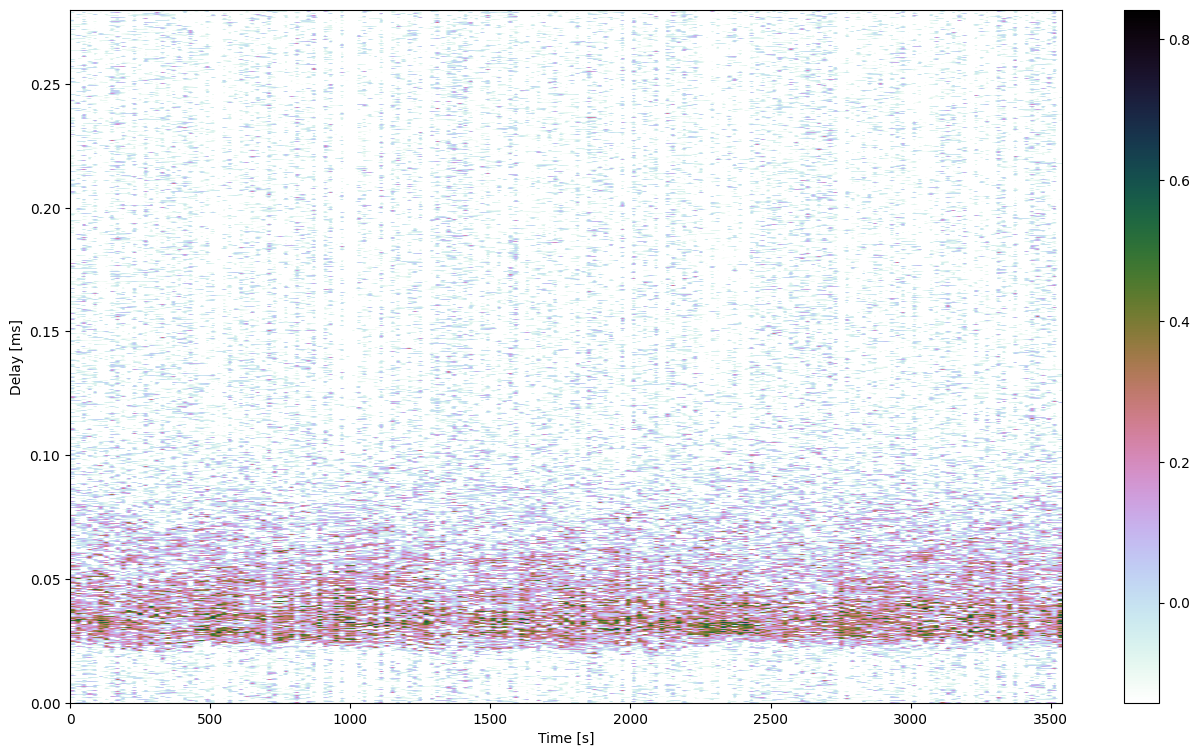

In [5]:
def plot_time_vs_delay (h_time_delay, dT, cfreq, bw):

    ntime, ntap = h_time_delay.shape
    
    power = np.sum(np.abs(h_time_delay)**2) / (ntime * ntap)
    print(f"Average Power: {power}")
 
    plotthis = np.log10(np.abs(h_time_delay) + 1e-2)
    plotmed = np.median(plotthis)

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 1e-3
    extent=[0, dT*ntime, 0, max_delay_ms]
    
    fig, ax = plt.subplots(figsize=(16, 9))
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Delay [ms]")
    fig.colorbar(img)

plot_time_vs_delay(h_time_delay, dT, cfreq, bw)

## Unaligned Wavefield

A Fourier transform along the delay axis yields $H(\nu,t)$, which is then passed to the plot function, which computes and plots the 2D FFT, $h(\tau,\omega)$.  This is expected to look like white Doppler noise because of the large time shifts $\epsilon_t$ that are clearly visible in the above plot.

rms=0 rad; S=16.60152406148396 grad power phs=2.413e-05 eps=1.832e-06
Spectral Entropy: 16.60152406148396


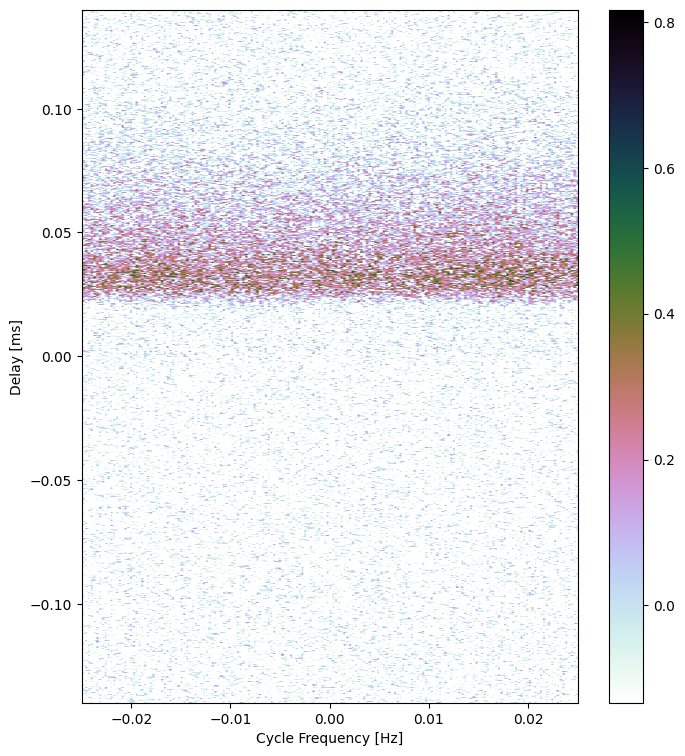

In [6]:
def plot_Doppler_vs_delay (h_time_freq, dT, cfreq, bw):

    print(f"Spectral Entropy: {spectral_entropy(h_time_freq)}")

    h_time_delay = freq2time(h_time_freq, axis=1)
    h_doppler_delay = time2freq(h_time_delay, axis=0)

    ntime, ntap = h_time_delay.shape

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 0.5e-3
    max_Doppler_Hz = .5 / dT
    
    extent=[-max_Doppler_Hz, max_Doppler_Hz, -max_delay_ms, max_delay_ms]
    
    plotthis = np.log10(np.abs(fftshift(h_doppler_delay)) + 1e-2)
    plotmed = np.median(plotthis)
    fig, ax = plt.subplots(figsize=(8, 9))

    ax.set_xlabel("Cycle Frequency [Hz]")
    ax.set_ylabel("Delay [ms]")
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    fig.colorbar(img)
    
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

## Coarse alignment using the cross-correlation function.

Each impulse response in $h(\tau,t)$ is aligned to its neighbour and multiplied by a phase term, based on the cross-correlation between them.

In [7]:
def align_to_neighbour(subset):
    power = np.sum(np.abs(subset)**2,axis=1)
    max_idx = np.argmax(power)

    print(f"{max_idx=}")
    x = subset[max_idx]

    nt, ntau = subset.shape
    lags = signal.correlation_lags(ntau, ntau, mode="full")

    def align (x, y, idx):
        correlation = signal.correlate(x, y, mode="full")
        cabs = np.abs(correlation)
        imax = np.argmax(cabs)
        maxval = np.max(correlation)
        lag = lags[imax]
        y[:] = np.roll(y, lag)
        ph = maxval / np.abs(maxval)
        y *= np.conj(ph)
        print(f"lag[{idx}] {lag=} {maxval=} {ph=}")
        
    for idx in range(max_idx+1,nt):
        y = subset[idx]
        align(x,y,idx)
        x = y
        subset[idx,:] = y

    x = subset[max_idx]
    for idx in range(1,max_idx+1):
        jdx = max_idx - idx
        y = subset[jdx]
        align(x,y,jdx)
        x = y
        subset[jdx,:] = y        

In [8]:
align_to_neighbour(h_time_delay)

max_idx=8
lag[9] lag=7 maxval=(79.999007400739-11.526194552246546j) ph=(0.9897794418514624-0.14260664952311103j)
lag[10] lag=4 maxval=(189.69035822728745+136.7105502231133j) ph=(0.8112635350503585+0.5846806621546463j)
lag[11] lag=6 maxval=(80.11268335417903-34.377391291272666j) ph=(0.9189647483518049-0.3943396902249431j)
lag[12] lag=9 maxval=(377.6492710712304-160.98466287235516j) ph=(0.9199062187043137-0.39213843064552023j)
lag[13] lag=5 maxval=(80.29249089650756-27.841048005051587j) ph=(0.9448131889597944-0.3276095816175466j)
lag[14] lag=-2 maxval=(73.25073422198619+8.786567849851036j) ph=(0.9928824819602712+0.11909818225485996j)
lag[15] lag=11 maxval=(434.25676879158164+94.54321701067106j) ph=(0.9771111276728719+0.21272950941947108j)
lag[16] lag=23 maxval=(194.25972707327372+173.52681742858988j) ph=(0.7457838519159737+0.666187996155269j)
lag[17] lag=8 maxval=(98.7150386092982+25.041076226743808j) ph=(0.9692996282420333+0.24588255466758158j)
lag[18] lag=-2 maxval=(83.81315436243437+7

## Coarsely-aligned Impulse Responses

It's reassuring to see temporally persistent features in the impulse responses.

Average Power: 1.0000000000000002


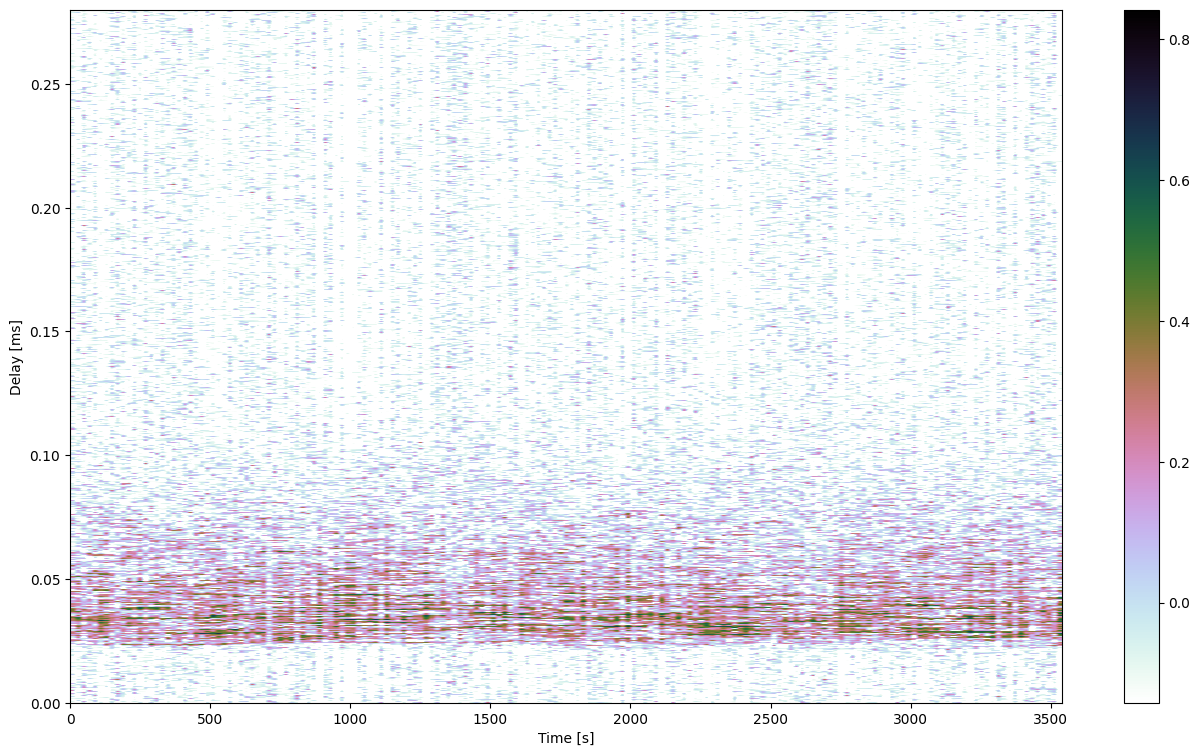

In [9]:
plot_time_vs_delay(h_time_delay, dT, cfreq, bw)

## Coarsely-aligned Wavefield

This still looks like white Doppler noise because of the remaining fractional time shifts $\epsilon_t$.

rms=0 rad; S=16.59851149993101 grad power phs=7.349e-05 eps=3.323e-06
Spectral Entropy: 16.59851149993101


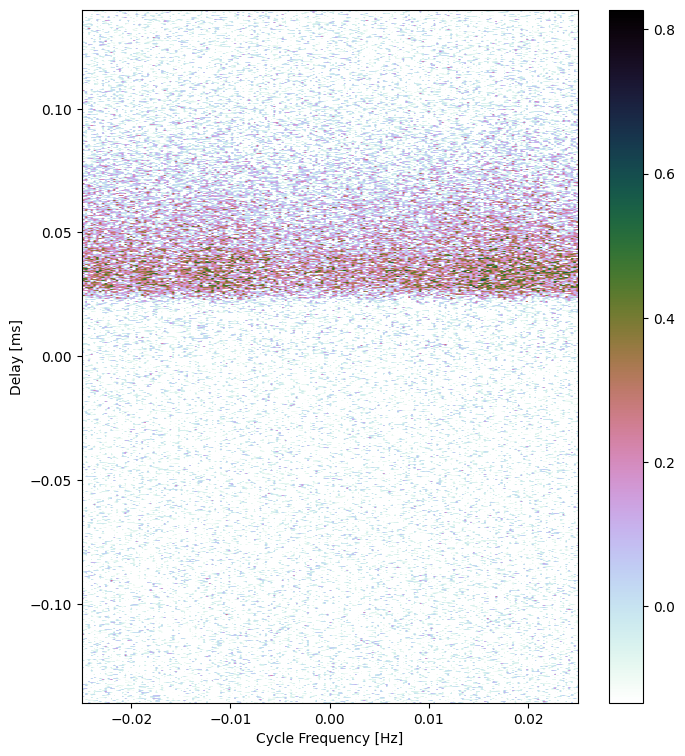

In [10]:
h_time_freq = fft(h_time_delay,axis=1,norm="ortho")
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

## Perform fine alignment by minimizing the spectral entropy

In [11]:
minimize_spectral_entropy(h_time_freq)

rms=0 rad; S=16.59851149993101 grad power phs=7.349e-05 eps=3.323e-06
rms=0.0006437 rad; S=16.598435148498982 grad power phs=7.39e-05 eps=3.331e-06
rms=0.003218 rad; S=16.59812765446883 grad power phs=7.556e-05 eps=3.365e-06
rms=0.01352 rad; S=16.596864758198624 grad power phs=8.237e-05 eps=3.5e-06
rms=0.05471 rad; S=16.5913231975385 grad power phs=0.0001111 eps=4.086e-06
rms=0.2195 rad; S=16.564390255796695 grad power phs=0.0002116 eps=6.784e-06
rms=0.8786 rad; S=16.541787659180464 grad power phs=0.000415 eps=9.859e-06
rms=0.5146 rad; S=16.528130646641173 grad power phs=0.0003809 eps=1.129e-05
rms=0.644 rad; S=16.526550266848833 grad power phs=0.0004673 eps=1.186e-05
rms=0.6048 rad; S=16.525574479337784 grad power phs=0.0004486 eps=1.191e-05
rms=0.5768 rad; S=16.524624503104192 grad power phs=0.0004334 eps=1.198e-05
rms=0.5534 rad; S=16.52291561741375 grad power phs=0.0004217 eps=1.216e-05
rms=0.532 rad; S=16.519717823792107 grad power phs=0.0004133 eps=1.254e-05
rms=0.5119 rad; S=16.

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


## Finely-aligned Wavefield

After fine alignment, an arc appears!  It's at a funny delay and Doppler shift, but it's a start!  The offeset in cycle frequency $\Delta\omega$ could be fixed by a applying a phase gradient along the time axis; i.e. $h^\prime(\tau,t)= h(\tau,t)\exp(i2\pi t\Delta\omega)$

rms=0 rad; S=15.859041437889235 grad power phs=1.173e-06 eps=2.901e-07
Spectral Entropy: 15.859041437889235


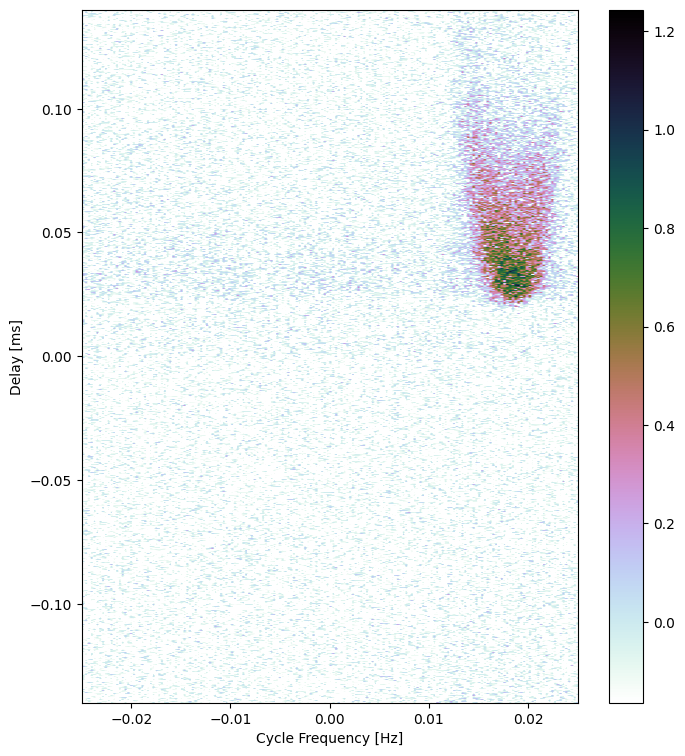

In [12]:
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)